In [8]:
import sys
sys.path.append('..')
import theano.tensor as T
import theano
import numpy
import network_optimizers
import lstm_network_components
import theano_lstm
import numpy as np
import data_managers
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
reload(theano_lstm)
reload(lstm_network_components)
network = theano_lstm.lstm_rnn( 300, [(128,100)], 150 )

In [33]:
inp_sym = T.tensor3()
len_sym = T.ivector()
targ_sym = T.dmatrix()

y,_,_,_,_,_ = network.LSTM_stack.process(inp_sym, len_sym)

pre_p = T.transpose( T.dot(network.soft_reader.w, y) )

p = network.soft_reader.process(y)

cost = T.mean(T.nnet.binary_crossentropy(p, targ_sym))

fun = theano.function( [inp_sym, len_sym], [y, pre_p, p] )


g_fun = theano.function( [inp_sym, len_sym, targ_sym], T.grad( cost, network.list_all_params() ) )

In [163]:
data_butler = data_managers.character_data_manager('/Users/alex/Desktop/data manager/',
                                                   batch_size=1,perms_per=2)

In [182]:
data_butler.convert_ent_to_one_hot()

In [133]:
data_butler.advance_schedule()

In [173]:
scale_down = 0.55
b_f_offset = 0.75

network.initialize_network_weights(b_f_offset=b_f_offset/scale_down)

for P in network.list_all_params():
    P.set_value(P.get_value()*scale_down)
    
for L in network.LSTM_stack.layers:
    L.set_c_clip(100000000.)

In [195]:
data_butler.advance_schedule()
vectors,lengths,answers = data_butler.offer_data()
vectors.shape

(1438, 300, 2)

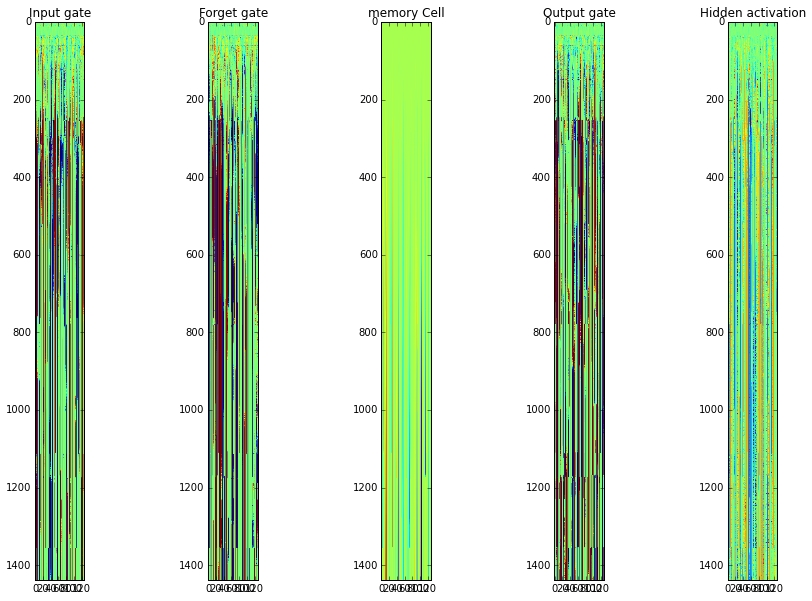

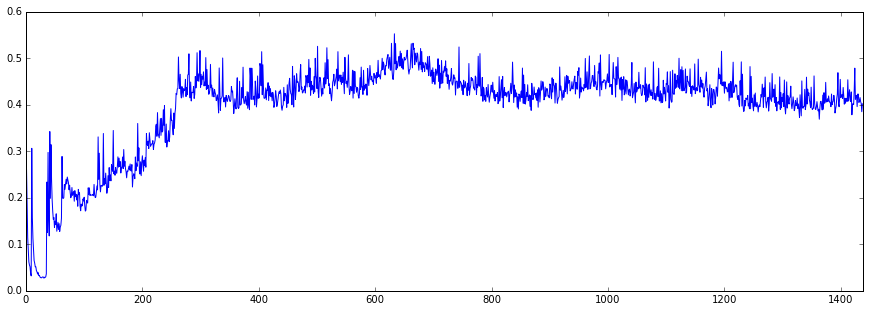

In [196]:
labels = ['Input gate','Forget gate','memory Cell','Output gate','Hidden activation']
fig = plt.figure(figsize=(15,10))

ax_list = []
for sp in range(len(labels)):
    ax_list.append(fig.add_subplot(1,len(labels),sp+1))

hidden_players = network.hidden_activations(vectors[:,:,:2])
for ax,gtp,title in zip(ax_list, hidden_players, labels):
    ax.imshow(gtp[:lengths[1],:,1]-gtp[:lengths[0],:,0])
    #ax.imshow(gtp[:,:,0])
    ax.set_title(title)
    
plt.figure(figsize=(15,5))
ax = plt.axes();
ax.plot( np.mean(np.abs(hidden_players[4][:lengths[1],:256,1]-hidden_players[4][:lengths[0],:256,0]),axis=1) );
ax.set_xlim([0,lengths[0]]);

In [197]:
gs = g_fun(vectors,lengths,answers)

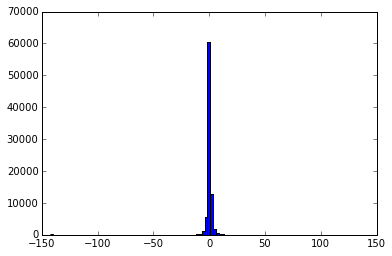

In [194]:
plt.hist(gs[6].flatten(),bins=100);

In [101]:
y, pp, p = fun(vectors,lengths)

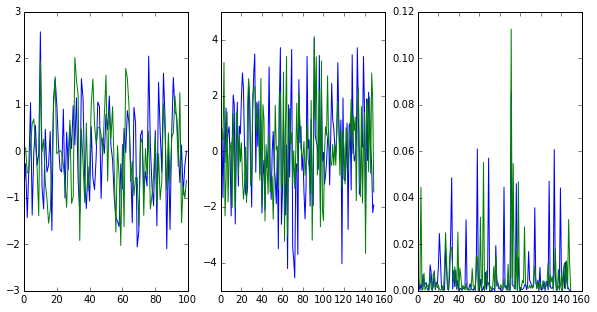

In [102]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(131).plot(y)
fig.add_subplot(132).plot(pp.T)
fig.add_subplot(133).plot(p)

# plt.plot(p);